# Google vit-large-patch32-384 AI Model for Image classification (1000 classes)

Testing with and without CUDA Graph from PyTorch on one Image and on multiple Images

In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

import torch
from torch.profiler import profile, record_function, ProfilerActivity
import torchvision

from PIL import Image
import matplotlib.pyplot as plt
import time
import os

# check gpu
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch32-384')
model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384', device_map=device)

model.eval()

/home/00/dmehlhorn/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


/home/00/dmehlhorn/.local/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/opt/easybuild/software/PyTorch/2.1.2-foss-2023a-CUDA-12.1.1/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_f

## Test with 1 Image on GPU

### Warmup

In [3]:
# loads an images from file
input = []
dir = "./images"

for image in os.listdir(dir):
    image = Image.open(os.path.join(dir, image))
    img = feature_extractor(images=image, return_tensors="pt")
    input.append(img['pixel_values'])
    if len(input) == 10:
        break

### Without CUDA Graph

In [15]:
start_time = time.perf_counter()
# warmup
for i in range(10):
    with torch.no_grad():
        output = model(input[1].to(device))
        logits = output.logits
torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=0, warmup=0, active=1, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/v100/one_image/no_cuda_graph'),
    record_shapes=True,
) as prof:
    with record_function("model_inference"):
        # make prediction
        output = model(input[1].to(device))
        logits = output.logits

        torch.cuda.synchronize()

        # model predicts one of the 1000 ImageNet classes
        predicted_class_idx = logits.argmax(-1).item()
        prof.step()
            
        end_time = time.perf_counter()
    
print("Predicted class:", model.config.id2label[predicted_class_idx])
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")

STAGE:2024-03-13 13:56:39 2245718:2245718 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-13 13:56:39 2245718:2245718 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-13 13:56:39 2245718:2245718 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Predicted class: great grey owl, great gray owl, Strix nebulosa
Time: 0.25790012115612626
Time with warmup: 0.4755588830448687


### With CUDA Graph

In [5]:
static_input = torch.rand(1, 3, 384, 384, device=device)
static_input.copy_(input[1])

start_time = time.perf_counter()
# warmup
s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)

torch.cuda.synchronize()

# capture
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
        static_output = model(static_input).logits

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=0, warmup=0, active=1, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/v100/one_image/cuda_graph'),
    record_shapes=True,
) as prof:

    with record_function("copy data"):
        static_input.copy_(input[1])
    
    with record_function("model_inference"):
        # replay graph
        g.replay()

        torch.cuda.synchronize()

        # model predicts one of the 1000 ImageNet classes
        predicted_class_idx = logits.argmax(-1).item()
        prof.step()

    end_time = time.perf_counter()
    
print("Predicted class:", model.config.id2label[predicted_class_idx])
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")

Predicted class: great grey owl, great gray owl, Strix nebulosa
Time: 0.03917819890193641
Time with warmup: 0.4222161779180169


STAGE:2024-03-13 13:55:03 2245718:2245718 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-13 13:55:03 2245718:2245718 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-13 13:55:03 2245718:2245718 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


### Show image for comparison

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


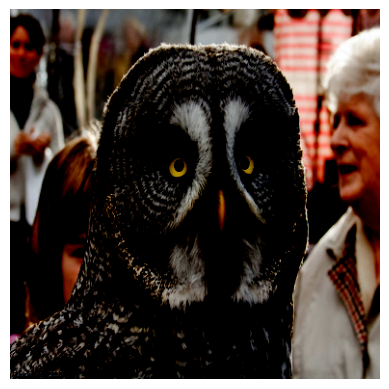

In [6]:
numpy_image = input[1].cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(numpy_image)
plt.axis('off')
plt.show()

## Test with many Images

In [7]:
folder_dir = "./images"
images = [os.path.join(folder_dir, file_name) for file_name in os.listdir(folder_dir) if file_name.endswith(".JPEG")]

### Without CUDA Graph

In [8]:
count = 0
pred = {}

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
inputs = inputs['pixel_values'].to(device)
with torch.no_grad():
    for i in range(10):
        outputs = model(inputs).logits
torch.cuda.synchronize()


start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/v100/many_images/no_cuda_graph'),
    record_shapes=True,
) as prof:
       
    for i in range(len(images)):
        with record_function("load_image"):
            input_image = Image.open(images[i])

        with record_function("feature_extractor"):
            # convert image to tensor and put on gpu
            inputs = feature_extractor(images=input_image, return_tensors="pt")
            inputs = inputs['pixel_values'].to(device)

        with record_function("model_inference"):
            # make prediction
            outputs = model(inputs).logits

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[images[i]] = model.config.id2label[outputs.argmax(-1).item()]

        count += 1
        prof.step()
        
    end_time = time.perf_counter()

print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

STAGE:2024-03-13 13:55:04 2245718:2245718 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-13 13:55:04 2245718:2245718 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-13 13:55:04 2245718:2245718 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Time: 6.771507885074243
Time with warmup: 6.993834879016504
Predicted images: 149


In [9]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

./images/ILSVRC2012_val_00046917.JPEG: magpie, 
./images/ILSVRC2012_val_00018062.JPEG: great grey owl, great gray owl, Strix nebulosa, 
./images/ILSVRC2012_val_00049244.JPEG: European fire salamander, Salamandra salamandra, 
./images/ILSVRC2012_val_00046252.JPEG: tench, Tinca tinca, 
./images/ILSVRC2012_val_00021776.JPEG: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui, 
./images/ILSVRC2012_val_00018092.JPEG: vulture, 
./images/ILSVRC2012_val_00030740.JPEG: tench, Tinca tinca, 
./images/ILSVRC2012_val_00033960.JPEG: bullfrog, Rana catesbeiana, 
./images/ILSVRC2012_val_00039445.JPEG: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, 
./images/ILSVRC2012_val_00030918.JPEG: common newt, Triturus vulgaris, 
./images/ILSVRC2012_val_00044755.JPEG: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea, 
./images/ILSVRC2012_val_00024545.JPEG: banded gecko, 
./images/ILSVRC2012_val_00036066.JPEG: tree frog, tree-frog, 
./images

### With CUDA Graph

In [10]:
count = 0
pred = {}

static_input = torch.rand(1, 3, 384, 384).to(device)

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
static_input.copy_(inputs['pixel_values'])

s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.no_grad(), torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture graph
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    static_output = model(static_input).logits

torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/v100/many_images/cuda_graph'),
    record_shapes=True,
) as prof:
    
    for i in range(len(images)):
        with record_function("load_image"):
            input_image = Image.open(images[i])

        with record_function("feature_extractor"):
            # convert image to tensor and copy to gpu
            inputs = feature_extractor(images=input_image, return_tensors="pt")
            static_input.copy_(inputs['pixel_values'])

        with record_function("model_inference"):
            # replay graph
            g.replay()

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[images[i]] = model.config.id2label[static_output.argmax(-1).item()]
                
        count += 1
        prof.step()

    end_time = time.perf_counter()
    
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

STAGE:2024-03-13 13:55:11 2245718:2245718 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-13 13:55:11 2245718:2245718 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-13 13:55:11 2245718:2245718 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Time: 4.189269925002009
Time with warmup: 4.565744095016271
Predicted images: 149


In [11]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

./images/ILSVRC2012_val_00046917.JPEG: magpie, 
./images/ILSVRC2012_val_00018062.JPEG: great grey owl, great gray owl, Strix nebulosa, 
./images/ILSVRC2012_val_00049244.JPEG: European fire salamander, Salamandra salamandra, 
./images/ILSVRC2012_val_00046252.JPEG: tench, Tinca tinca, 
./images/ILSVRC2012_val_00021776.JPEG: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui, 
./images/ILSVRC2012_val_00018092.JPEG: vulture, 
./images/ILSVRC2012_val_00030740.JPEG: tench, Tinca tinca, 
./images/ILSVRC2012_val_00033960.JPEG: bullfrog, Rana catesbeiana, 
./images/ILSVRC2012_val_00039445.JPEG: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, 
./images/ILSVRC2012_val_00030918.JPEG: common newt, Triturus vulgaris, 
./images/ILSVRC2012_val_00044755.JPEG: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea, 
./images/ILSVRC2012_val_00024545.JPEG: banded gecko, 
./images/ILSVRC2012_val_00036066.JPEG: tree frog, tree-frog, 
./images

prepairing next image, while cpu is idle waiting for gpu to finish prediction

In [12]:
count = 1
pred = {}

static_input = torch.rand(1, 3, 384, 384).to(device)

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
static_input.copy_(inputs['pixel_values'])

s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture graph
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    static_output = model(static_input).logits

torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/v100/many_images/cuda_graph_next_image'),
    record_shapes=True,
) as prof:

    # load first image
    with record_function("load_image"):
        input_image = Image.open(images[0])

    with record_function("feature_extractor"):
        # convert image to tensor and copy to gpu
        inputs = feature_extractor(images=input_image, return_tensors="pt")
        static_input.copy_(inputs['pixel_values'])

    for i in range(1, len(images)):
        with record_function("model_inference"):
            # replay graph
            g.replay()

            # load next image
            with record_function("load_next_image_and_feature_extractor"):
                input_image = Image.open(images[i])
                inputs = feature_extractor(images=input_image, return_tensors="pt")

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[count] = model.config.id2label[static_output.argmax(-1).item()]

            with record_function("copy_data"):
                static_input.copy_(inputs['pixel_values'])
                
        count += 1
        prof.step()
    
    # predict last image
    with record_function("model_inference"):
            # replay graph
            g.replay()
    
    with record_function("save_prediction"):
            # add prediction and filename to dictionary
            pred[count] = model.config.id2label[static_output.argmax(-1).item()]

    end_time = time.perf_counter()
    
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

STAGE:2024-03-13 13:55:15 2245718:2245718 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-13 13:55:15 2245718:2245718 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-13 13:55:15 2245718:2245718 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Time: 2.4909275509417057
Time with warmup: 2.994749803096056
Predicted images: 149


In [13]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

1: magpie, 
2: great grey owl, great gray owl, Strix nebulosa, 
3: European fire salamander, Salamandra salamandra, 
4: tench, Tinca tinca, 
5: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui, 
6: vulture, 
7: tench, Tinca tinca, 
8: bullfrog, Rana catesbeiana, 
9: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, 
10: common newt, Triturus vulgaris, 
11: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea, 
12: banded gecko, 
13: tree frog, tree-frog, 
14: great grey owl, great gray owl, Strix nebulosa, 
15: spotted salamander, Ambystoma maculatum, 
16: common iguana, iguana, Iguana iguana, 
17: eft, 
18: great grey owl, great gray owl, Strix nebulosa, 
19: jay, 
20: kite, 
21: whiptail, whiptail lizard, 
22: hammerhead, hammerhead shark, 
23: common iguana, iguana, Iguana iguana, 
24: hammerhead, hammerhead shark, 
25: water ouzel, dipper, 
26: hen, 
27: terrapin, 
28: mud turtle, 
29: ostrich, Struthio camelus, 
3

## Profiler to check CUDA Graph capture

In [14]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    # capture graph
    g = torch.cuda.CUDAGraph()
    with torch.cuda.graph(g):
        static_output = model(static_input).logits

prof.export_chrome_trace(f"log/v100/CUDAGraph_capture_v100.json")

STAGE:2024-03-13 13:55:17 2245718:2245718 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-13 13:55:18 2245718:2245718 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-13 13:55:18 2245718:2245718 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
